In [1]:
!pip install googletrans==4.0.0-rc1


In [2]:
!python -m spacy download de_core_news_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 23.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
from google.cloud import bigquery
client_bq = bigquery.Client.from_service_account_json("./credentials.json", project='charged-dialect-824')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import spacy

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import nltk
from nltk.corpus import stopwords
from collections import Counter
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from googletrans import Translator

# Download the stopwords list if not already downloaded
nltk.download('stopwords')

# Load German stopwords from NLTK
stop_words = set(stopwords.words('german'))

# Tokenize the cleaned text and extract stopwords
stopword_counts = Counter()

# Initialize translator
translator = Translator()

# Load spaCy's German language model
nlp = spacy.load('de_core_news_sm')

# Tokenize the cleaned text, lemmatize non-stopwords and count frequency
lemmatized_counts = Counter()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Loading data from BQ

In [5]:
def load_bq_data(_sql):
    _df = client_bq.query(_sql).to_dataframe()
    return _df

In [6]:
sql = """
SELECT *
FROM RicardoInterview.product_detection_training_data
"""

df_load = load_bq_data(sql)
len(df_load)
df_load.head()

,articleId,title,subtitle,productType
0,-3393892867263864215,Gone Is Gone - Echolocation,Gone Is Gone - Echolocation,cd
1,-2831118468819601923,Ekseption-The Lost Last Concert Tapes...,The Lost Last Concert Tapes (Box-Set),cd
2,6835807414137785977,PORTISHEAD CD-Sammlung 3 CDs #16,Kollektion für Fans der Trip-Hop-Pioniere aus ...,cd
3,-4912458353746230865,Primeon CD-R Rohlinge (bunt),39 Stück auf der Spindel,cd
4,1496864991301777371,Adonia - Zmittst im Füür,Markus Hottiger / Markus Heusser,cd


# Preprocessing

In [7]:
print("Get data types")
df_load.dtypes

Get data types


,0
articleId,Int64
title,object
subtitle,object
productType,object


In [8]:
print(f"Number of unique products in dataframe {len(df_load.productType.unique())}")
print(f"Number of articles in dataframe {len(df_load.articleId.unique())}")
print(f"Number of rows in dataframe {len(df_load)}")

Number of unique products in dataframe 383
Number of articles in dataframe 37032
Number of rows in dataframe 37567


In [9]:
print("Remove duplicates")
df = df_load.drop_duplicates()
print(f"Number of unique products in dataframe {len(df.productType.unique())}")
print(f"Number of articles in dataframe {len(df.articleId.unique())}")

Remove duplicates
Number of unique products in dataframe 383
Number of articles in dataframe 37032


In [10]:
print("Checking for None values...")
df_null = df[df.isna().any(axis=1)]
print(f"Found {len(df_null)}")

print("Check for empty string values...")
df_empty = df[(df == '').any(axis=1)]
print(f"Found {len(df_empty)}")
empty_string_columns = (df == '').sum()
print("Columns with empty string values:")
print(empty_string_columns[empty_string_columns > 0])

Checking for None values...
Found 0
Check for empty string values...
Found 21023
Columns with empty string values:
title           2
subtitle    21023
dtype: Int64


In [11]:
print("Fill empty string")
df.loc[df['title'] == '', 'title'] = 'No title'
df.loc[df['subtitle'] == '', 'subtitle'] = 'No description'

Fill empty string


In [12]:
print("Clean title and subtitle values for training")
def clean_text(text):
    # Convert to string
    text = str(text)
    # Convert to lower case
    text = text.lower()
    # Remove special characters
    text = re.sub(r'[^a-z\s]', '', text)
    return text

# Apply the cleaning function to 'title' and 'subtitle' columns
df.loc[:, 'title'] = df['title'].apply(clean_text)
df.loc[:, 'subtitle'] = df['subtitle'].apply(clean_text)

# Optionally, check the cleaned text
df[['title', 'subtitle']].head()

Clean title and subtitle values for training


,title,subtitle
0,gone is gone echolocation,gone is gone echolocation
1,ekseptionthe lost last concert tapes,the lost last concert tapes boxset
2,portishead cdsammlung cds,kollektion fr fans der triphoppioniere aus bri...
3,primeon cdr rohlinge bunt,stck auf der spindel
4,adonia zmittst im fr,markus hottiger markus heusser


In [13]:
# Count the number of articles by productType
product_type_counts = df['productType'].value_counts()

# Display the distribution
print("Distribution of Articles by Product Type:")
print(product_type_counts)


Distribution of Articles by Product Type:
productType
radio_controlled_model    99
cd                        99
pc                        99
portable_media_player     99
bag                       99
                          ..
handrail                  59
holster                   59
jukebox                   59
dump_truck                52
marble                    46
Name: count, Length: 383, dtype: int64


In [14]:
# Summary statistics
mean_count = product_type_counts.mean()
median_count = product_type_counts.median()
std_count = product_type_counts.std()
min_count = product_type_counts.min()
max_count = product_type_counts.max()

# Display summary statistics
print("\nSummary Statistics:")
print(f"Mean count of articles per product type: {mean_count:.2f}")
print(f"Median count of articles per product type: {median_count}")
print(f"Standard deviation: {std_count:.2f}")
print(f"Minimum count of articles: {min_count}")
print(f"Maximum count of articles: {max_count}")

# Check for imbalanced classes
class_imbalance = product_type_counts / len(df)
print(f"Class imbalance: \n{class_imbalance}")



Summary Statistics:
Mean count of articles per product type: 96.80
Median count of articles per product type: 99.0
Standard deviation: 6.54
Minimum count of articles: 46
Maximum count of articles: 99
Class imbalance: 
productType
radio_controlled_model    0.002670
cd                        0.002670
pc                        0.002670
portable_media_player     0.002670
bag                       0.002670
                            ...   
handrail                  0.001591
holster                   0.001591
jukebox                   0.001591
dump_truck                0.001403
marble                    0.001241
Name: count, Length: 383, dtype: float64


In [15]:
print("Combine title and subtitle into a single column")
df.loc[:, 'text_combined'] = df['title'] + ' ' + df['subtitle']

Combine title and subtitle into a single column


<ipython-input-15-e36fc1347d04>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'text_combined'] = df['title'] + ' ' + df['subtitle']


<ipython-input-16-075928236b40>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'title_length'] = df['title'].apply(len)
<ipython-input-16-075928236b40>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'subtitle_length'] = df['subtitle'].apply(len)


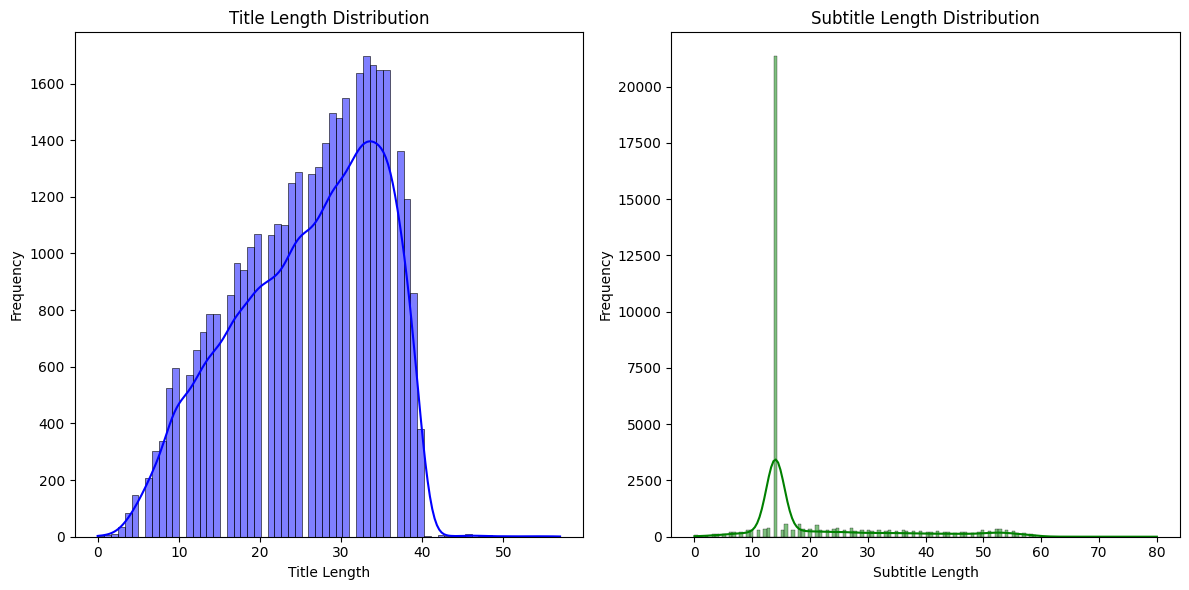

In [16]:
# Create a column for the length of title and subtitle
df.loc[:, 'title_length'] = df['title'].apply(len)
df.loc[:, 'subtitle_length'] = df['subtitle'].apply(len)

# Plot the length distributions
plt.figure(figsize=(12, 6))

# Title Length
plt.subplot(1, 2, 1)
sns.histplot(df['title_length'], kde=True, color='blue')
plt.title('Title Length Distribution')
plt.xlabel('Title Length')
plt.ylabel('Frequency')

# Subtitle Length
plt.subplot(1, 2, 2)
sns.histplot(df['subtitle_length'], kde=True, color='green')
plt.title('Subtitle Length Distribution')
plt.xlabel('Subtitle Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


<ipython-input-17-45764722176d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='productType', y='title_length', data=df, palette='Set3')


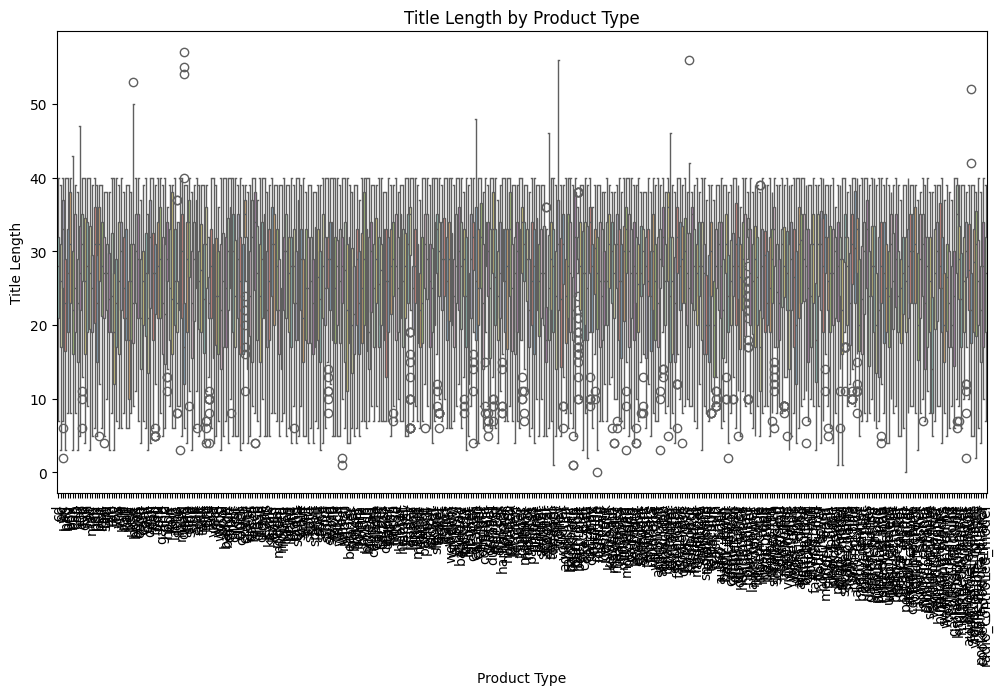

<ipython-input-17-45764722176d>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='productType', y='subtitle_length', data=df, palette='Set3')


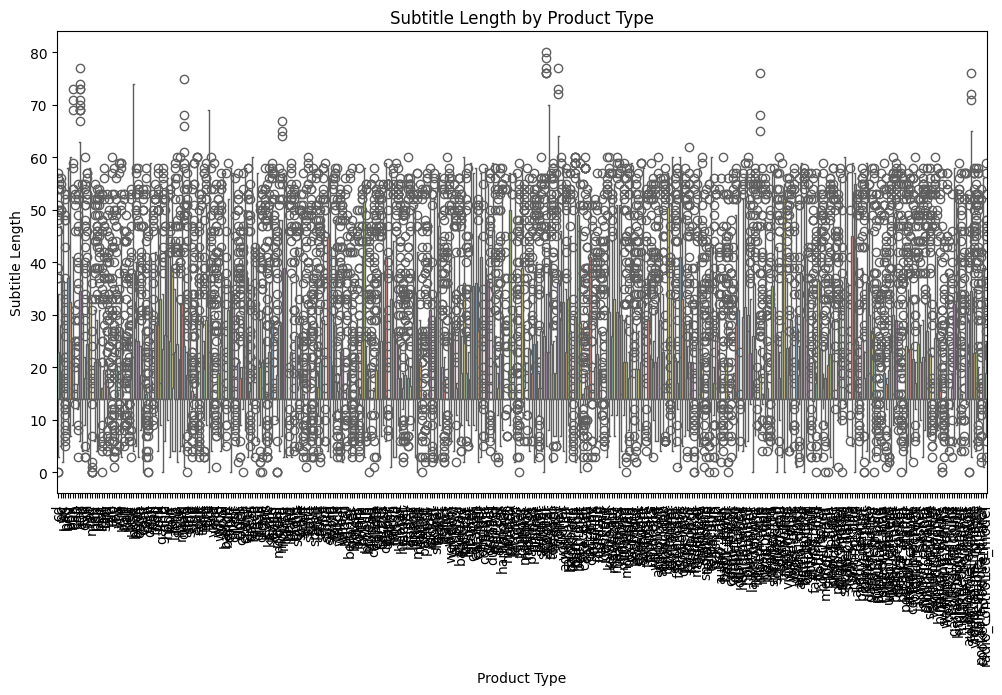

In [17]:
plt.figure(figsize=(12, 6))

# Plot title length vs product type
sns.boxplot(x='productType', y='title_length', data=df, palette='Set3')
plt.xticks(rotation=90)
plt.title('Title Length by Product Type')
plt.xlabel('Product Type')
plt.ylabel('Title Length')
plt.show()

# Plot subtitle length vs product type
plt.figure(figsize=(12, 6))
sns.boxplot(x='productType', y='subtitle_length', data=df, palette='Set3')
plt.xticks(rotation=90)
plt.title('Subtitle Length by Product Type')
plt.xlabel('Product Type')
plt.ylabel('Subtitle Length')
plt.show()


<ipython-input-18-ae6ee6d5161d>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='productType', data=df, palette='Set2')


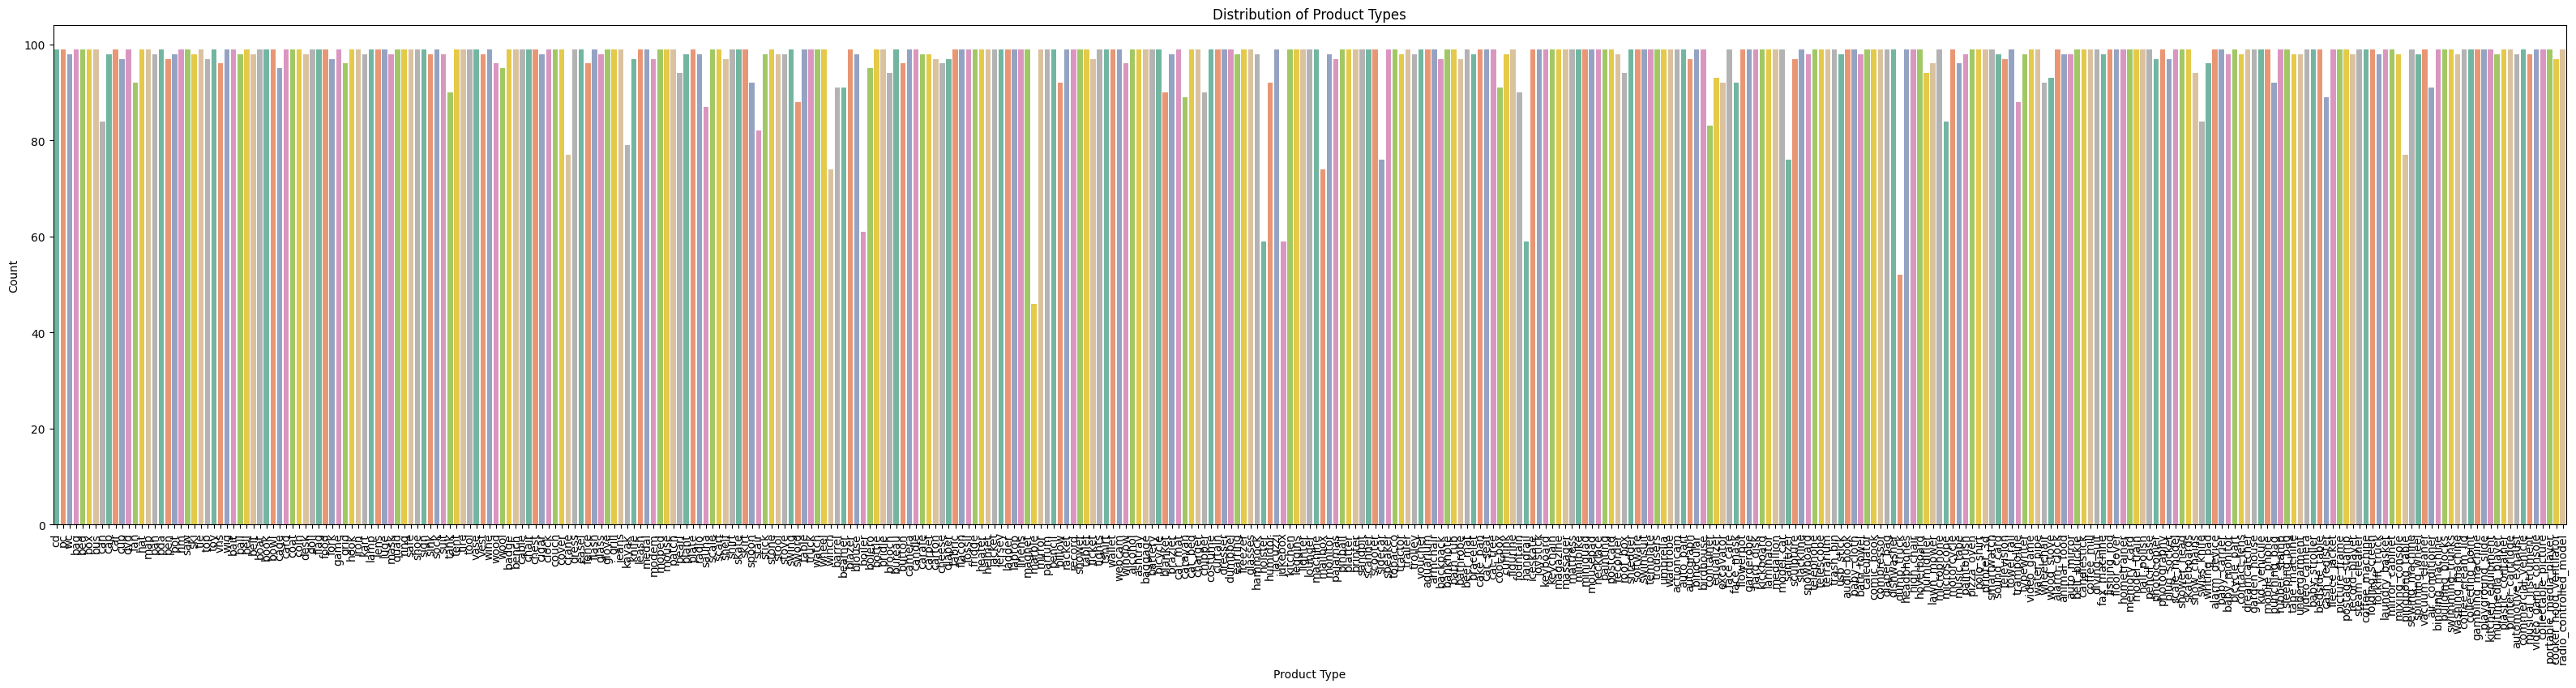

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of product types
plt.figure(figsize=(40, 8))
sns.countplot(x='productType', data=df, palette='Set2')
plt.xticks(rotation=90)
plt.title('Distribution of Product Types')
plt.xlabel('Product Type')
plt.ylabel('Count')
plt.show()


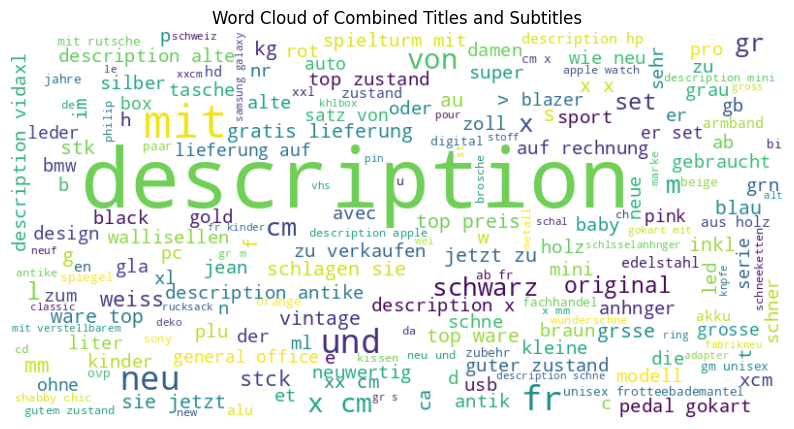

In [19]:
from wordcloud import WordCloud

# Combine the title and subtitle columns
text_combined = ' '.join(df['text_combined'])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_combined)

# Plot the word cloud
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Combined Titles and Subtitles')
plt.show()


<ipython-input-20-4e786d3088e8>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=product_type_counts.index, y=product_type_counts.values, palette='viridis')


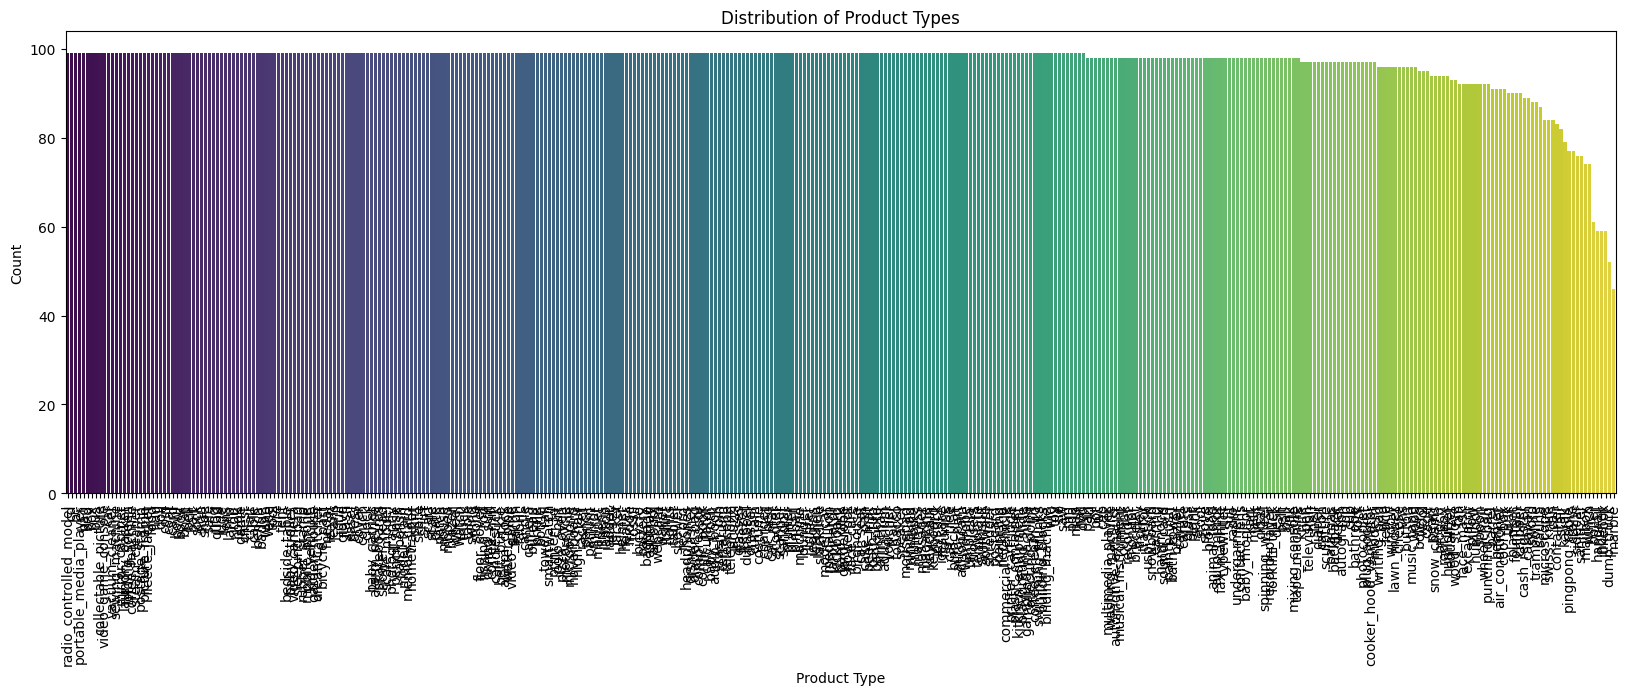

In [20]:
# Check the balance of product types
product_type_counts = df['productType'].value_counts()

# Plot the distribution of product types
plt.figure(figsize=(20, 6))
sns.barplot(x=product_type_counts.index, y=product_type_counts.values, palette='viridis')
plt.xticks(rotation=90)
plt.title('Distribution of Product Types')
plt.xlabel('Product Type')
plt.ylabel('Count')
plt.show()




In [21]:
print("Analyze Word Frequency (Including Stopwords)")
from collections import Counter
import re

# Tokenize the cleaned text
all_words = ' '.join(df['text_combined']).split()

# Get word frequencies
word_freq = Counter(all_words)

# Show the most common words
print("Most Common Words:")
print(word_freq.most_common(20))

Analyze Word Frequency (Including Stopwords)
Most Common Words:
[('no', 21087), ('description', 21023), ('mit', 3605), ('x', 2349), ('fr', 2244), ('cm', 1906), ('und', 1385), ('neu', 1346), ('von', 1029), ('gr', 989), ('in', 982), ('aus', 922), ('top', 908), ('m', 908), ('de', 856), ('mm', 695), ('s', 657), ('schwarz', 655), ('set', 615), ('l', 607)]


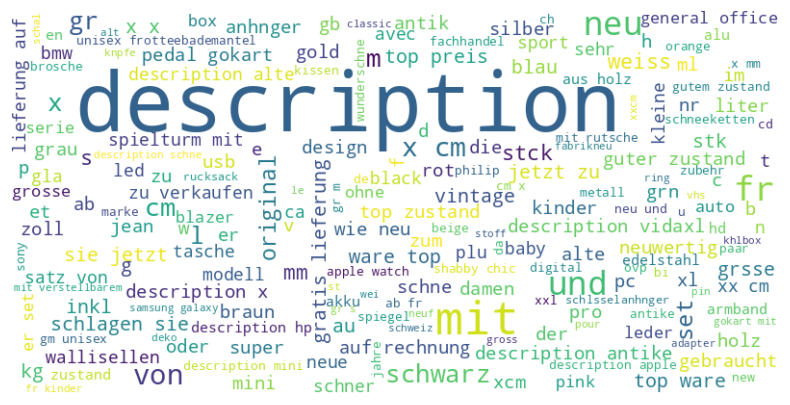

In [22]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate a wordcloud from the cleaned text
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_words))

# Display the wordcloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # No axes for the wordcloud
plt.show()


<ipython-input-23-834adcdb3b27>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Stopword (translation)', data=df_stopwords.head(20), palette='Blues_d')


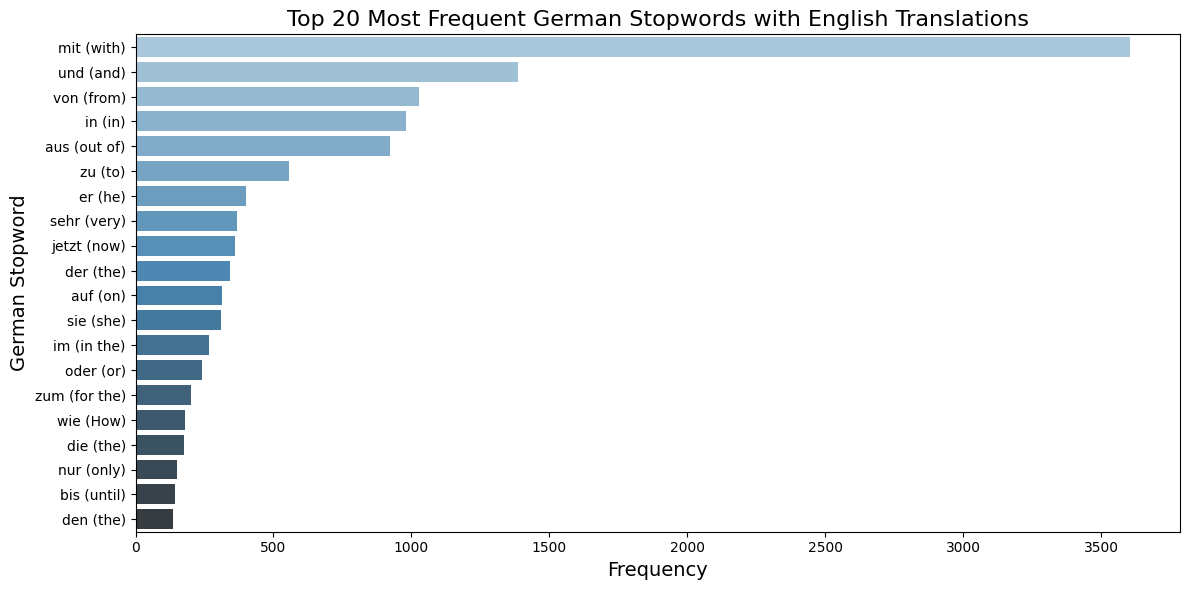

In [23]:




for text in df['text_combined']:
    words = text.split()
    for word in words:
        if word in stop_words:
            stopword_counts[word] += 1

# Translate stopwords to English
stopword_translations = {word: translator.translate(word, src='de', dest='en').text for word in stopword_counts.keys()}

# Convert the stopword counts and their translations to a DataFrame for plotting
stopword_data = {
    'German Stopword': list(stopword_counts.keys()),
    'Frequency': list(stopword_counts.values()),
    'English Translation': [stopword_translations[word] for word in stopword_counts.keys()]
}

df_stopwords = pd.DataFrame(stopword_data)

# Sort the DataFrame by frequency for better plotting
df_stopwords = df_stopwords.sort_values(by='Frequency', ascending=False)

df_stopwords["Stopword (translation)"] = df_stopwords["German Stopword"] + " (" + df_stopwords["English Translation"] + ")"

# Create the seaborn barplot
plt.figure(figsize=(12, 6))
sns.barplot(x='Frequency', y='Stopword (translation)', data=df_stopwords.head(20), palette='Blues_d')

# Add titles and labels
plt.title("Top 20 Most Frequent German Stopwords with English Translations", fontsize=16)
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('German Stopword', fontsize=14)

# Show plot
plt.tight_layout()
plt.show()


In [27]:
for text in df['text_combined']:
    doc = nlp(text.lower())  # Lowercase and process text
    for token in doc:
        if token.text not in stop_words and not token.is_punct:  # Exclude stopwords and punctuation
            lemmatized_counts[token.lemma_] += 1

# Translate lemmatized words to English
lemmatized_translations = {word: translator.translate(word, src='de', dest='en').text for word in lemmatized_counts.keys()}

# Convert the lemmatized counts and their translations to a DataFrame for plotting
lemmatized_data = {
    'Lemmatized Word': list(lemmatized_counts.keys()),
    'Frequency': list(lemmatized_counts.values()),
    'English Translation': [lemmatized_translations[word] for word in lemmatized_counts.keys()]
}

df_lemmatized = pd.DataFrame(lemmatized_data)

df_lemmatized["Lemmatized Word (translation)"] = df_lemmatized["Lemmatized Word"] + " (" + df_lemmatized["English Translation"] + ")"

# Sort the DataFrame by frequency for better plotting
df_lemmatized = df_lemmatized.sort_values(by='Frequency', ascending=False)

# Create the seaborn barplot
plt.figure(figsize=(12, 6))
sns.barplot(x='Frequency', y='Lemmatized Word (translation)', data=df_lemmatized.head(20), palette='Blues_d')

# Add titles and labels
plt.title("Top 20 Most Frequent Lemmatized Words with English Translations", fontsize=16)
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Lemmatized Word', fontsize=14)

# Show plot
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

In [30]:
# 2. Tokenization (using TensorFlow's Tokenizer)
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df.text_combined)

# Convert texts to sequences
sequences = tokenizer.texts_to_sequences(df.text_combined)

# 2. Convert sequences back to words
reverse_word_index = {index: word for word, index in tokenizer.word_index.items()}

# Function to convert a sequence of integers back to words
def sequence_to_text(sequence):
    return " ".join([reverse_word_index.get(i, "<OOV>") for i in sequence])

# Apply to all sequences
texts_from_sequences = [sequence_to_text(seq) for seq in sequences]

# Show the first 5 examples
for i in range(5):
    print(f"Original Text: {df.text_combined.iloc[i]}")
    print(f"Tokenized Sequences: {sequences[i]}")
    print(f"Reconstructed Text: {texts_from_sequences[i]}")
    print("---------")


Original Text: gone is gone  echolocation gone is gone  echolocation
Tokenized Sequences: [4427, 1464, 4427, 1, 4427, 1464, 4427, 1]
Reconstructed Text: gone is gone <OOV> gone is gone <OOV>
---------
Original Text: ekseptionthe lost last concert tapes the lost last concert tapes boxset
Tokenized Sequences: [1, 4428, 4429, 5178, 7881, 91, 4428, 4429, 5178, 7881, 7882]
Reconstructed Text: <OOV> lost last concert tapes the lost last concert tapes boxset
---------
Original Text: portishead cdsammlung  cds  kollektion fr fans der triphoppioniere aus bristol
Tokenized Sequences: [1, 1, 2601, 2242, 6, 4430, 39, 1, 13, 1]
Reconstructed Text: <OOV> <OOV> cds kollektion fr fans der <OOV> aus <OOV>
---------
Original Text: primeon cdr rohlinge bunt  stck auf der spindel
Tokenized Sequences: [1, 1, 6270, 1168, 33, 46, 39, 4431]
Reconstructed Text: <OOV> <OOV> rohlinge bunt stck auf der spindel
---------
Original Text: adonia  zmittst im fr markus hottiger  markus heusser
Tokenized Sequences: [1, 

In [31]:
reverse_word_index

{1: '<OOV>',
 2: 'no',
 3: 'description',
 4: 'mit',
 5: 'x',
 6: 'fr',
 7: 'cm',
 8: 'und',
 9: 'neu',
 10: 'von',
 11: 'gr',
 12: 'in',
 13: 'aus',
 14: 'top',
 15: 'm',
 16: 'de',
 17: 'mm',
 18: 's',
 19: 'schwarz',
 20: 'set',
 21: 'l',
 22: 'a',
 23: 'zu',
 24: 'vidaxl',
 25: 'grsse',
 26: 'gb',
 27: 'lieferung',
 28: 'original',
 29: 'zustand',
 30: 'inkl',
 31: 'weiss',
 32: 'er',
 33: 'stck',
 34: 'ab',
 35: 'sehr',
 36: 'jetzt',
 37: 'holz',
 38: 'd',
 39: 'der',
 40: 't',
 41: 'pro',
 42: 'usb',
 43: 'gratis',
 44: 'vintage',
 45: 'kg',
 46: 'auf',
 47: 'sie',
 48: 'blau',
 49: 'preis',
 50: 'v',
 51: 'rot',
 52: 'kinder',
 53: 'mini',
 54: 'im',
 55: 'silber',
 56: 'stk',
 57: 'g',
 58: 'xl',
 59: 'schlagen',
 60: 'oder',
 61: 'ware',
 62: 'c',
 63: 'ml',
 64: 'led',
 65: 'en',
 66: 'gebraucht',
 67: 'pour',
 68: 'iphone',
 69: 'hp',
 70: 'damen',
 71: 'w',
 72: 'xcm',
 73: 'ca',
 74: 'zum',
 75: 'alte',
 76: 'apple',
 77: 'zubehr',
 78: 'f',
 79: 'i',
 80: 'samsung',
 81: 

In [ ]:
# Calculate the number of words/tokens in each text
df['num_words'] = df['text_combined'].apply(lambda x: len(x.split()))

# Plot word count distribution
plt.figure(figsize=(12, 6))
sns.histplot(df['num_words'], kde=True, color='purple')
plt.title('Number of Words per Article')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

# Display some summary statistics on word counts
print(df['num_words'].describe())


In [ ]:


# Initialize the tokenizer
tokenizer = Tokenizer()

# Fit the tokenizer on your combined text column
tokenizer.fit_on_texts(df['text_combined'])

# Convert the texts into sequences of tokens
sequences = tokenizer.texts_to_sequences(df['text_combined'])


In [ ]:
sequences

In [33]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

# Assuming your dataframe 'df' contains 'text_combined' and 'productType' columns

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text_combined'], df['productType'], test_size=0.2, random_state=42)

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=5000)

# Fit the vectorizer to the training data and transform both training and testing data
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Initialize the Naive Bayes classifier
classifier = MultinomialNB()

# Train the classifier on the training data
classifier.fit(X_train, y_train)

# Predict on the test data
y_pred = classifier.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 61.11%

Classification Report:
                        precision    recall  f1-score   support

             actioncam       0.44      0.79      0.56        14
       air_conditioner       0.73      0.40      0.52        20
           alarm_clock       0.78      0.78      0.78        18
          alarm_device       0.43      0.50      0.46        18
               alcohol       0.47      0.41      0.44        22
           animal_food       1.00      0.12      0.22        24
              aquarium       0.80      0.95      0.87        21
              armchair       0.67      0.40      0.50        20
               ashtray       0.89      0.94      0.91        17
            audio_book       0.27      0.59      0.37        17
           auto_mirror       0.59      0.77      0.67        22
             auto_part       0.56      0.23      0.32        22
             autograph       0.50      0.56      0.53        16
    automotive_exhaust       0.43      0.35      0.39        1

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# To be implemented